# Stock Explorer

The first step in this project is actually getting the raw stock data from Alpha Vantage and processing into a form ready for training.

Before starting this process you must get an API key from this [site](https://www.alphavantage.co/support/#api-key).

## 1. Load some necessary modules

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas_datareader import data
import pickle
import random
from scipy.optimize import minimize_scalar
import seaborn as sns
import time
import yaml

from alpha_vantage.timeseries import TimeSeries

%matplotlib inline

## 2. Read the user defined settings

In [2]:
with open('settings.yml') as f:
    settings = yaml.safe_load(f)

## 3. Download the stock history
Note you have to manually enter your Alpha Vantage API key in the following cell.  It is unique to each user and is limited to 5 API requests per minute and 500 requests per day, so _**please don't use someone else's key!!!!!**_

This notebook saves the stock data in `stock-data.pkl` and doesn't get new data if the stock data already exists.  Therefore if you want a new data, just delete the `stock-data.pkl` file in your local folder.

In [5]:
# Set your API key
api_key = 'AIM9J0PA8YV2A12F'

# Format connection
ts = TimeSeries(key=api_key, output_format='pandas')

# Read saved data if it exists
if os.path.isfile('stock-data.pkl'):
    saved_stocks = pd.read_pickle('stock-data.pkl')
    saved_stock_names = saved_stocks.columns.to_list()
else:
    saved_stock_names = []
    
# To avoid hitting the 5 requests per minute, we only pull 1 per 12 sec
times = []
stocks = []
failed = []
for ticker in settings['tickers']:
    if ticker in saved_stock_names:
        stocks.append(saved_stocks.loc[:, [ticker]])
    else:
        if len(times) >= 5:
            delta = 61 - (time.time() - times[-5])
            if delta > 0:
                print("Taking a {:.0f}s break to avoid 5 req/min limit.".format(delta))
                time.sleep(delta)
        
        print("Reading {} from API.".format(ticker))
        try:
            data, _ = ts.get_daily_adjusted(symbol=ticker, outputsize='full')
            data = data.rename(columns={'5. adjusted close': ticker})
            stocks.append(data.loc[:, [ticker]])
        except:
            print("\tFailed to pull {} from API.".format(ticker))
            failed.append(ticker)
        times.append(time.time())
stocks = pd.concat(stocks, axis=1)
stocks.to_pickle('stock-data.pkl')
if len(failed) > 0:
    print("Failed to get following tickers from API:")
    print(failed)

Reading BCE.TO from API.
Reading RCI-B.TO from API.
Reading SJR-B.TO from API.
Reading T.TO from API.
Reading CJR-B.TO from API.
Taking a 44s break to avoid 5 req/min limit.
Reading MG.TO from API.
Taking a 3s break to avoid 5 req/min limit.
Reading TOY.TO from API.
Taking a 3s break to avoid 5 req/min limit.
Reading QSR.TO from API.
Taking a 2s break to avoid 5 req/min limit.
Reading GC.TO from API.
Taking a 1s break to avoid 5 req/min limit.
Reading GOOS.TO from API.
Taking a 46s break to avoid 5 req/min limit.
Reading CTC.TO from API.
Reading GIL.TO from API.
Taking a 1s break to avoid 5 req/min limit.
Reading DOL.TO from API.
Taking a 3s break to avoid 5 req/min limit.
Reading ATD-B.TO from API.
Reading L.TO from API.
Taking a 46s break to avoid 5 req/min limit.
Reading MRU.TO from API.
Taking a 0s break to avoid 5 req/min limit.
Reading SAP.TO from API.
Reading MFI.TO from API.
Taking a 0s break to avoid 5 req/min limit.
Reading ENB.TO from API.
Reading CNQ.TO from API.
Taking a 4

Plot the data to visually check for bad data.  You may want to manually play with the plotting to find data of interest.

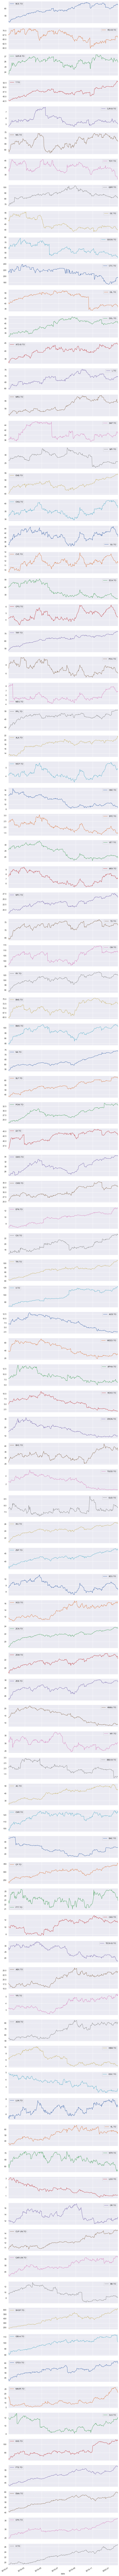

In [12]:
sns.set(color_codes=True)
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

Since our investment horizon is so short, we are only concerned with data after the start of 2019.  So we will deleted the data before 2019 and also delete any stocks that don't have data during 2019 until now.

In [13]:
stocks = stocks.loc['2018-12-31':, :]
stocks = stocks.loc[:, ~stocks.isna().any()]
stocks.shape

(274, 98)

Looks like there was also some bad data at the source so I am going to 'fill' the missing data with a linear interpolation.

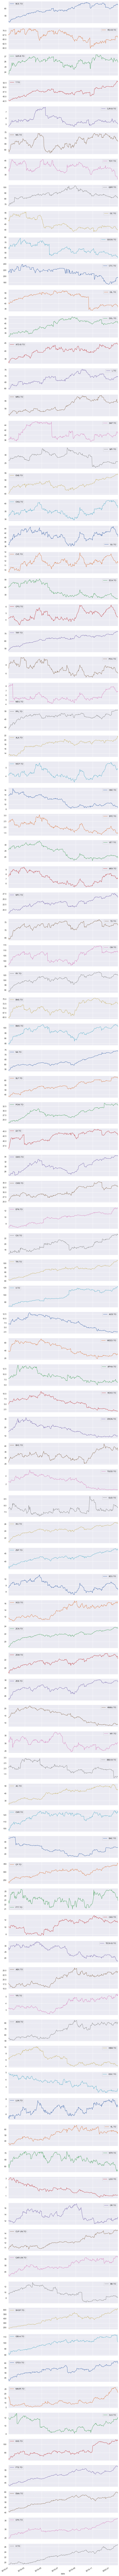

In [14]:
stocks = stocks.replace(0, np.nan).interpolate()
_ = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

**Now that's a pretty dataset!!!**

## 4. Calculate weekly and monthly returns

Since our investment time horizon is 10 weeks or 2.5 months, we won't concern ourselves with daily returns. We will also limit the return values to -/+ 1, since these were clearly freak events that would add any trend information.

In [15]:
names = stocks.columns.tolist()
dates = stocks.index.tolist()
returns = np.empty((len(dates), len(names), 2))
for i, dt in enumerate([5, 20]):
    returns[:, :, i] = stocks.pct_change(periods=dt).clip(-1, 1).values

A few little plots to double check the return calcuations

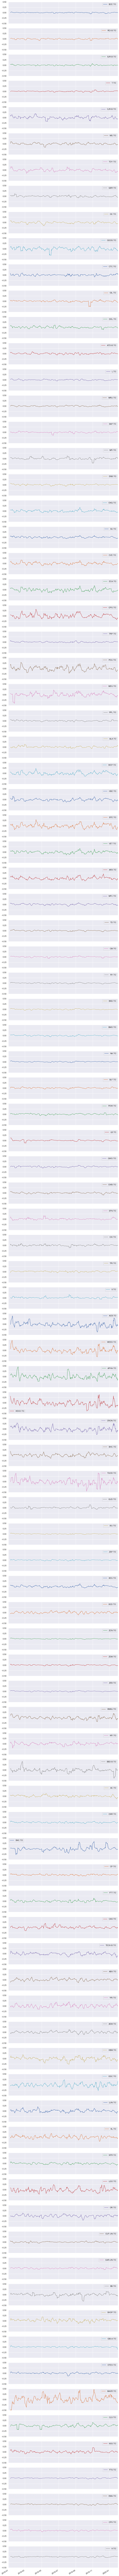

In [25]:
# Weekly Returns
i = 0
tmp = pd.DataFrame(returns[:, :, i], index=dates, columns=names)
e = max(np.nanmax(returns[:, :, i]), -np.nanmin(returns[:, :, i]))
_ = tmp.plot(figsize=(11, 3*stocks.shape[1]), subplots=True, ylim=(-e, e))
plt.show()

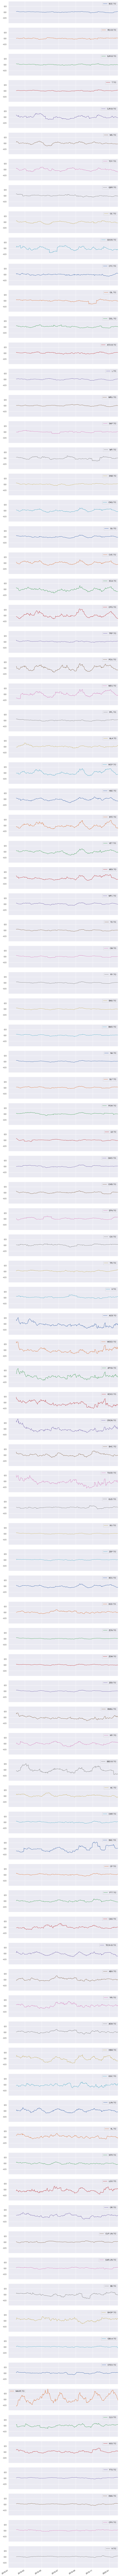

In [26]:
# Monthly returns
i = 1
tmp = pd.DataFrame(returns[:, :, i], index=dates, columns=names)
e = max(np.nanmax(returns[:, :, i]), -np.nanmin(returns[:, :, i]))
_ = tmp.plot(figsize=(11, 3*stocks.shape[1]), subplots=True, ylim=(-e, e))
plt.show()